In [ ]:
#default_exp simclr

# SimCLR

> [A Simple Framework for Contrastive Learning of Visual Representations](https://arxiv.org/pdf/2002.05709.pdf)

In [1]:
#export
from fastai.vision.all import *
from self_supervised.augmentations import *

## Data Augmentation

We can use batch data augmentation utilities form `self_supervised.augmentations` module.

In [2]:
#hide
img = PILImage(PILImage.create(TEST_IMAGE).resize((600,400)))
t = Pipeline([ToTensor(), IntToFloatTensor(), Resize(256)])(img)
type(img), type(t)

(fastai.vision.core.PILImage, fastai.torch_core.TensorImage)

Default SimCLR augmentations side by side with the original image

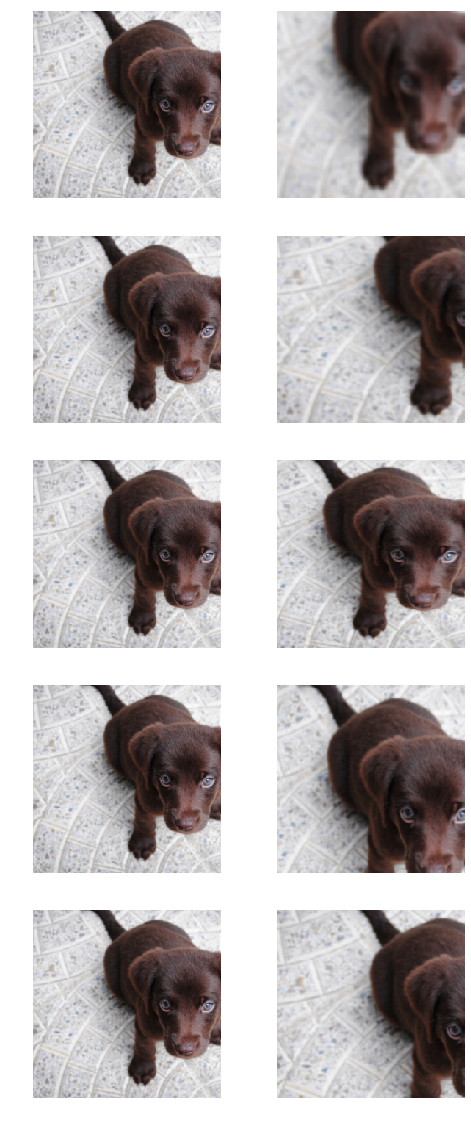

In [6]:
aug = get_batch_augs(224, cuda=False)
n = 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n):
    show_image(t,ax=ax[i][0])
    show_image(aug.decode(aug(t)).clamp(0,1)[0], ax=ax[i][1])

Default SimCLR augmentations with extra transforms passed by user side by side with the original image

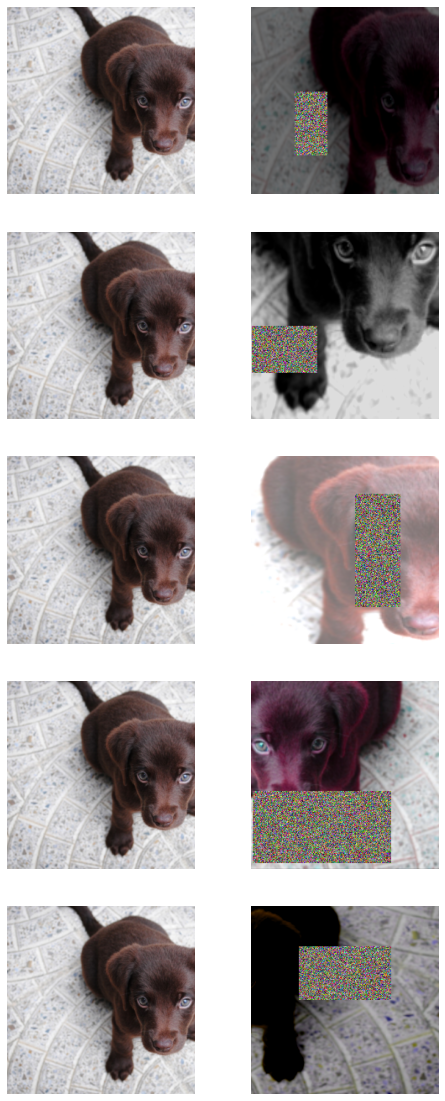

In [ ]:
aug = get_aug_pipe(224, xtra_tfms=[RandomErasing(p=1.)])
n = 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n):
    show_image(t,ax=ax[i][0])
    show_image(aug.decode(aug(t)).clamp(0,1)[0], ax=ax[i][1])

## Architecture

![](images/simclr.png)

In [ ]:
#export
def create_encoder(arch, n_in=3, pretrained=True, cut=None, concat_pool=True):
    "Create encoder from a given arch backbone"
    encoder = create_body(arch, n_in, pretrained, cut)
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    return nn.Sequential(*encoder, pool, Flatten())

This function creates an encoder which essentially outputs the embeddings/representations we learn through self-supervised training. It uses `create_body` function from fastai, you can pass any `arch` that is supported, specify number of input channels with `n_in`, optionally load `pretrained` weights if available and or use `concat_pool`. Instead of directly using this function you will most likely call `create_simclr_model` when creating your model.

In [ ]:
encoder = create_encoder(xresnet18, n_in=3, pretrained=False, concat_pool=True)
encoder[-2:]

Sequential(
  (8): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (9): Flatten(full=False)
)

In [ ]:
#export
class MLP(Module):
    "MLP module as described in paper"
    def __init__(self, dim, projection_size=128, hidden_size=256):
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, projection_size)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
#export
class SimCLRModel(Module):
    "Compute predictions of concatenated xi and xj" 
    def __init__(self,encoder,projector): self.encoder,self.projector = encoder,projector
    def forward(self,x): return self.projector(self.encoder(x))

In [ ]:
#export
def create_simclr_model(arch=resnet50, n_in=3, pretrained=True, cut=None, concat_pool=True,
                      hidden_size=256, projection_size=128):
    "Create SimCLR from a given arch"
    encoder = create_encoder(arch, n_in, pretrained, cut, concat_pool)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = MLP(representation.size(1), projection_size, hidden_size=hidden_size)     
    apply_init(projector)
    return SimCLRModel(encoder, projector)

This function creates a `SimCLRModel` with specified arguments. It uses `create_encoder` which is defined earlier. You can also define `hidden_size` for the `MLP` module and the `projection_size`.

In [ ]:
model = create_simclr_model(pretrained=False)
model.projector

MLP(
  (net): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
)

## SimCLR Callback

In [ ]:
#export
def remove_diag(x):
    bs = x.shape[0]
    return x[~torch.eye(bs).bool()].reshape(bs,bs-1)

In [ ]:
#export
class SimCLRLoss(Module):
    "SimCLR loss function"
    def __init__(self, temp=0.1):
        self.temp = temp
        
    def forward(self, inp, targ):
        bs,feat = inp.shape
        csim = F.cosine_similarity(inp, inp.unsqueeze(dim=1), dim=-1)/self.temp
        csim = remove_diag(csim)
        targ = remove_diag(torch.eye(targ.shape[0], device=inp.device)[targ]).nonzero()[:,-1]
        return F.cross_entropy(csim, targ)

Loss function allows you to specify `temp` which is the temperature parameter to be used in cross entropy loss. It calculates cosine similarity of different views of the same image to be used as the prediction

In [ ]:
x = torch.randn(16,128)
y = torch.arange(16).roll(16//2)
loss_func = SimCLRLoss(temp=0.1)
loss_func(x,y)

tensor(3.0830)

In [ ]:
#export
class SimCLR(Callback):
    "SimCLR callback"
    def __init__(self, size=256, **aug_kwargs):
        self.aug1 = get_aug_pipe(size, **aug_kwargs)
        self.aug2 = get_aug_pipe(size, **aug_kwargs)
                    
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)
        bs = self.learn.xb[0].shape[0]
        self.learn.yb = (torch.arange(bs, device=self.dls.device).roll(bs//2),)
        
    def show_one(self):
        xb = TensorImage(self.learn.xb[0])
        bs = len(xb)//2
        i = np.random.choice(bs)
        xb = self.aug1.decode(xb.to('cpu').clone()).clamp(0,1)
        images = [xb[i], xb[bs+i]]
        show_images(images)

You can pass `size` to define the random resized crop size and other data augmentation arguments defined in `get_aug_pipe` through `aug_kwargs`. Also, with `show_one()` method you can inspect data augmentations as a sanity check

### Example Usage

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=2, after_item=[ToTensor(), IntToFloatTensor()])

In [ ]:
model = create_simclr_model(arch=resnet18, n_in=1, pretrained=False)
learn = Learner(dls, model, SimCLRLoss(temp=0.5),
                cbs=[SimCLR(size=28, color=False, stats=None),
                     ShortEpochCallback(0.001)])

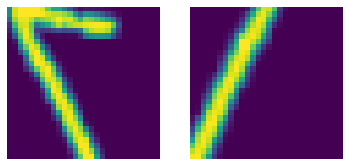

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.sim_clr.show_one()

In [ ]:
#hide
learn._split(b)
learn('before_batch')
out = learn.model(*learn.xb)
assert out.shape[0] == 4

In [ ]:
learn.fit(1)

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 10-simclr.ipynb.
Converted 20-byol.ipynb.
Converted 30-swav.ipynb.
Converted index.ipynb.
